# **Project Analisis Sentimen: Aplikasi M-Paspor melalui Review Playstore**

Analisis sentimen adalah metode analisis untuk mengetahui emosi di balik sebuah teks. Tujuan analisis sentimen pada project ini adalah untuk mengetahui apakah review aplikasi M-Paspor di Playstore bersifat positif atau negatif. Manfaat dari project ini dapat digunakan untuk meningkatkan kepuasan pelanggan, khususnya untuk layanan pembuatan paspor.




# **1. Data Collection : Scraping menggunakan google-play-scraper**

Langkah scraping dataset dapat dicek melalui notebook terpisah "Scraping Dataset M-Paspor from Playstore"

# **2. Import Library**

In [1]:
!pip install pipreqs

In [2]:
# Install library untuk preprocessing kata berbahasa Indonesia
!pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.6 MB/s eta 0:00:00


In [3]:
# Import library untuk visualisasi data dan manipulasi data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import library untuk preprocessing
import re     # Untuk ekspresi reguler (regex)
import string # Untuk mengelola string
import nltk   # Natural Language Toolkit
from nltk.tokenize import word_tokenize # Untuk tokenisasi teks
from nltk.corpus import stopwords       # Untuk filtering stopwords pada teks
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory # Stemming bahasa Indonesia

# Import library untuk keperluan lexicon
import csv
import requests
from io import StringIO

# Untuk membuat visualisasi awan kata
from wordcloud import WordCloud

# Import library untuk algoritma ML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score

In [4]:
nltk.download('punkt_tab') # Unduh dataset yang diperlukan untuk tokenisasi
nltk.download('stopwords') # Unduh dataset stopwords

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# **3. Load Dataset, Assessing Data**

### Load Dataset

In [5]:
# Akses dataset hasil scraping yang disimpan di Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Unggah dataset hasil scraping
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/m-paspor.csv')

In [7]:
# Melihat jumlah baris dan kolom dataset
print(f"Dataset berisi {df.shape[0]} baris dan {df.shape[1]} kolom")

# Menampilkan preview data 1 baris
df.head(1)

Dataset berisi 17059 baris dan 11 kolom


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,0fb44994-87a1-42ee-bdfb-dc07e8d8bc64,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"bagus, membantu pembuatan paspor, tp ada bbrp ...",4,0,NaN,2025-04-30 07:39:19,NaN,NaN,NaN


### Assessing Data

In [8]:
# Menampilkan informasi ringkas dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17059 entries, 0 to 17058
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              17059 non-null  object
 1   userName              17059 non-null  object
 2   userImage             17059 non-null  object
 3   content               17059 non-null  object
 4   score                 17059 non-null  int64 
 5   thumbsUpCount         17059 non-null  int64 
 6   reviewCreatedVersion  14603 non-null  object
 7   at                    17059 non-null  object
 8   replyContent          8 non-null      object
 9   repliedAt             8 non-null      object
 10  appVersion            14603 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.4+ MB


In [9]:
# Menghapus kolom yang tidak diperlukan
df = df.drop(columns=['reviewId', 'userName', 'userImage', 'reviewCreatedVersion',
                      'replyContent', 'repliedAt', 'appVersion'])

In [10]:
# Cek duplikasi data
print(f"Jumlah duplikat pada data : {df.duplicated().sum()}")

Jumlah duplikat pada data : 0


In [11]:
# Menampilkan informasi ringkas dataset yang sudah dinilai
df.head()

,content,score,thumbsUpCount,at
0,"bagus, membantu pembuatan paspor, tp ada bbrp ...",4,0,2025-04-30 07:39:19
1,Semua karena anugerah Tuhan😇 Selamat ulang tah...,4,0,2025-04-30 05:36:41
2,apus aja aplikasi ngentod. dah mau keluar nege...,1,0,2025-04-30 02:35:20
3,makasih google mambatu saya,5,0,2025-04-30 02:27:22
4,Bagus,5,0,2025-04-30 02:20:50


# **4. Text Preprocessing**

In [12]:
def cleaningText(text):
  text = re.sub(r'[0-9]+', '', text)  # Menghapus angka
  text = re.sub(r'[^\w\s]', '', text) # Menghapus tanda baca
  text = text.replace('\n', '')       # Mengganti \n menjadi spasi
  text = text.strip(' ')              # Menghapus spasi di awal dan akhir string
  text = text.lower()                 # Mengubah text menjadi lower case
  return text

def tokenizingText(text):             # Fungsi untuk tokenisasi, mengubah text menjadi daftar kata
  text = word_tokenize(text)
  return text

def filteringText(text):              # Fungsi untuk menghapus stopwords bahasa indonesia dan english
  stopwords_tambahan = ['yg','dg','dgn','kalo','klo','hehe','ny','nya','na','tp',
                        'iya','yaa','ya','yah','yh','dah','iye','ye', 'yaaa',
                        'gak','gaa','g','di','ga','ngga','nggak','enggak','gada','gk','tdk',
                        'lgi','lg','lagi','loh','kah','woi','woii','woy','ku',
                        'jgn','aja', 'bg', 'mauu', 'dr', 'bgt', 'banget', 'pas',
                        'sih', 'utk', 'sampe', 'bener', 'udah', 'udh', 'trs', 'sy',
                        'krn', 'jd', 'stlh', 'kl','gk','tdk']
  listStopwords = stopwords.words('indonesian') + stopwords.words('english') + stopwords_tambahan
  filtered = []
  for word in text:
    if word not in listStopwords:
      filtered.append(word)
  text = filtered
  return text

In [13]:
# Menerapkan fungsi cleaning pada teks
df['text_cleaned'] = df['content'].apply(cleaningText)

# Menerapkan fungsi tokenisasi pada teks yang sudah diclean
df['text_tokenized'] = df['text_cleaned'].apply(tokenizingText)

# Menerapkan fungsi penghilang stopwords pada teks yang sudah ditokenize
df['text_filtered'] = df['text_tokenized'].apply(filteringText)

*be careful, this stemming process is slow (almost 30min)

In [14]:
# Menerapkan stemming pada teks yang sudah dihilangkan stopwordsnya
factory = StemmerFactory()
stemmer = factory.create_stemmer()

df['text_stemmed'] = df['text_filtered'].apply(lambda x: [stemmer.stem(word) for word in x])

In [15]:
# Menampilkan beberapa teks pada tahap preprocessing
df.head(5)

,content,score,thumbsUpCount,at,text_cleaned,text_tokenized,text_filtered,text_stemmed
0,"bagus, membantu pembuatan paspor, tp ada bbrp ...",4,0,2025-04-30 07:39:19,bagus membantu pembuatan paspor tp ada bbrp sa...,"[bagus, membantu, pembuatan, paspor, tp, ada, ...","[bagus, membantu, pembuatan, paspor, bbrp, sar...","[bagus, bantu, buat, paspor, bbrp, saran, alam..."
1,Semua karena anugerah Tuhan😇 Selamat ulang tah...,4,0,2025-04-30 05:36:41,semua karena anugerah tuhan selamat ulang tahu...,"[semua, karena, anugerah, tuhan, selamat, ulan...","[anugerah, tuhan, selamat, ulang, pernikahan, ...","[anugerah, tuhan, selamat, ulang, nikah, mama,..."
2,apus aja aplikasi ngentod. dah mau keluar nege...,1,0,2025-04-30 02:35:20,apus aja aplikasi ngentod dah mau keluar neger...,"[apus, aja, aplikasi, ngentod, dah, mau, kelua...","[apus, aplikasi, ngentod, negeri, gara, gara, ...","[apus, aplikasi, ngentod, negeri, gara, gara, ..."
3,makasih google mambatu saya,5,0,2025-04-30 02:27:22,makasih google mambatu saya,"[makasih, google, mambatu, saya]","[makasih, google, mambatu]","[makasih, google, mambatu]"
4,Bagus,5,0,2025-04-30 02:20:50,bagus,[bagus],[bagus],[bagus]


## **5. Labeling : Lexicon-based**

In [36]:
# Unggah data lexicon positive
response = requests.get('https://raw.githubusercontent.com/shofuratr/dataset/main/lexicon_positive.csv')

lexicon_positive_dict = dict()

reader = csv.reader(StringIO(response.text), delimiter=',')
next(reader)
# Menambahkan kata-kata positif dan skornya ke dalam dictionary
for row in reader:
  lexicon_positive_dict[row[0]] = int(row[1])

In [37]:
# Unggah data lexicon negative
response = requests.get('https://raw.githubusercontent.com/shofuratr/dataset/refs/heads/main/lexicon_negative.csv')

lexicon_negative_dict = dict()

reader = csv.reader(StringIO(response.text), delimiter=',')
next(reader)
# Menambahkan kata-kata negatif dan skornya ke dalam dictionary
for row in reader:
        lexicon_negative_dict[row[0]] = int(row[1])

In [38]:
# Fungsi untuk menghitung skor sentimen dan labelling dari sebuah text

def sentiment_analysis_lexicon_indonesia(text):
  score = 0

  for word in text:
    if (word in lexicon_positive_dict):
      score = score + lexicon_positive_dict[word]
    elif (word in lexicon_negative_dict):
      score = score + lexicon_negative_dict[word]

  sentimen = ''

  if (score >= 0):
    sentimen = 'positive'
  elif (score < 0):
    sentimen = 'negative'

  return score, sentimen

In [39]:
# Menyimpan kolom skor beserta label dalam dataset
results = df['text_stemmed'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df['polarity_score'] = results[0]
df['text_sentiment'] = results[1]

# Hasil text yang telah diberi label
print(df['text_sentiment'].value_counts())

text_sentiment
negative    9613
positive    7446
Name: count, dtype: int64


<Axes: title={'center': 'Jumlah Sentimen'}, ylabel='count'>

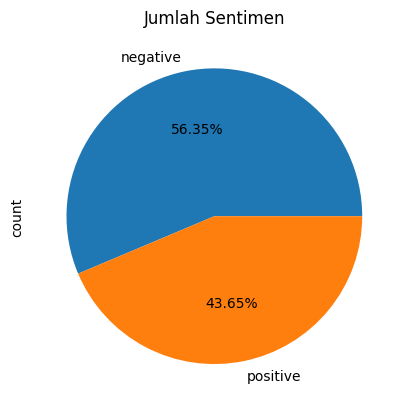

In [40]:
# Membuat pie chart hasil label
df['text_sentiment'].value_counts().plot(kind='pie', title='Jumlah Sentimen',
                                         autopct='%1.2f%%')

In [41]:
# Membuat dataframe baru
positive_review = df[df['text_sentiment'] == 'positive']
negative_review = df[df['text_sentiment'] == 'negative']

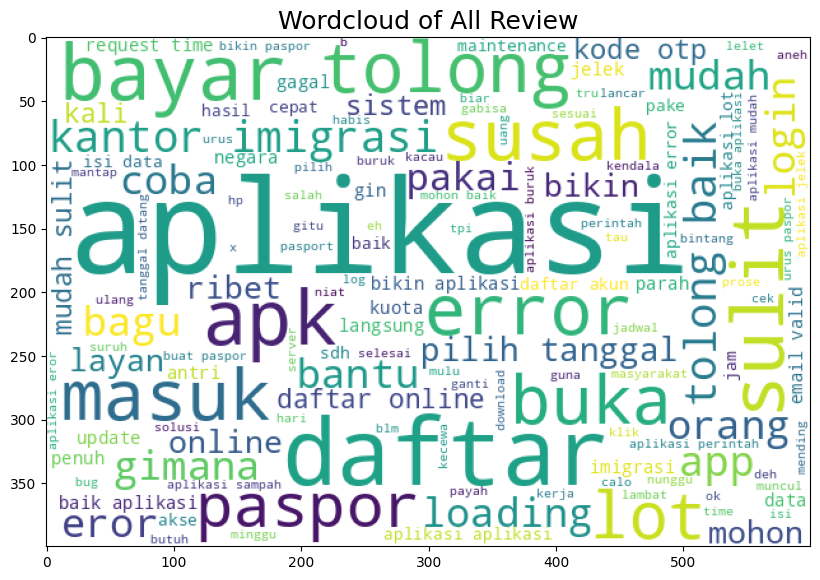

In [42]:
# Membuat WordCloud untuk semua kata
list_words = ''

for text in df['text_stemmed']:
  for word in text:
    list_words += ' ' + word

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8,6))
ax.set_title('Wordcloud of All Review', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
plt.show()

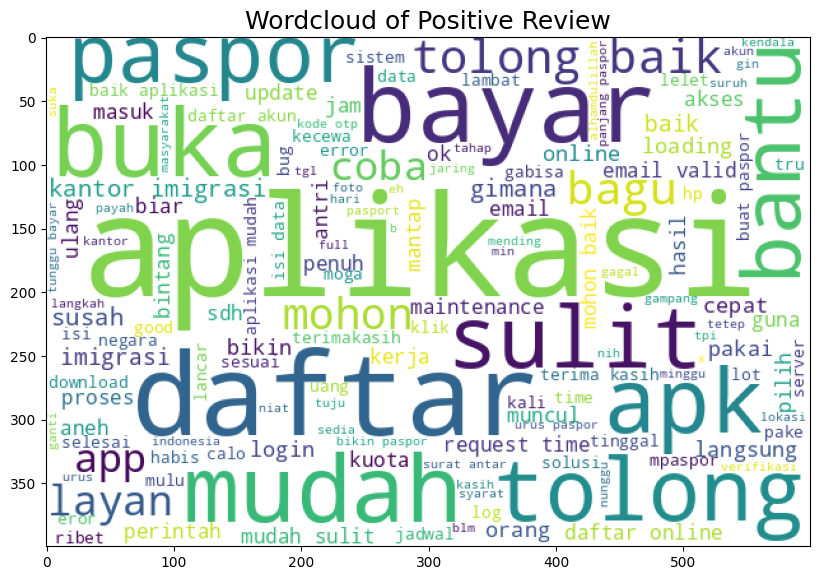

In [43]:
# Membuat WordCloud untuk kata dalam text berlabel positive
list_positive_words = ''

for text in positive_review['text_stemmed']:
  for word in text:
    list_positive_words += ' ' + word

wordcloud_n = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_positive_words)

fig, ax = plt.subplots(figsize=(8,6))
ax.set_title('Wordcloud of Positive Review', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud_n))
fig.tight_layout(pad=0)
plt.show()

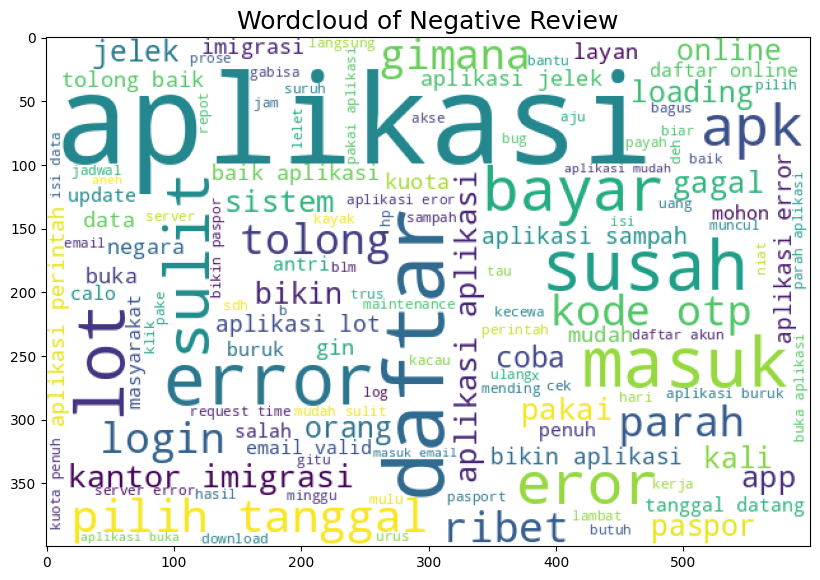

In [44]:
# Membuat WordCloud untuk kata dalam text berlabel negative
list_negative_words = ''

for text in negative_review['text_stemmed']:
  for word in text:
    list_negative_words += ' ' + word

wordcloud_n = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_negative_words)

fig, ax = plt.subplots(figsize=(8,6))
ax.set_title('Wordcloud of Negative Review', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud_n))
fig.tight_layout(pad=0)
plt.show()

## **6. Ekstraksi Fitur : TF-IDF**

In [45]:
df.head(1)

,content,score,thumbsUpCount,at,text_cleaned,text_tokenized,text_filtered,text_stemmed,polarity_score,text_sentiment
0,"bagus, membantu pembuatan paspor, tp ada bbrp ...",4,0,2025-04-30 07:39:19,bagus membantu pembuatan paspor tp ada bbrp sa...,"[bagus, membantu, pembuatan, paspor, tp, ada, ...","[bagus, membantu, pembuatan, paspor, bbrp, sar...","[bagus, bantu, buat, paspor, bbrp, saran, alam...",-2,negative


In [46]:
# Text yang sudah dipreprocessing diubah menjadi teks utuh
df['text_final'] = df['text_stemmed'].apply(lambda x: ' '.join(x))

In [47]:
# Pisahkan data text dan label
X = df['text_final']
y = df['text_sentiment']

In [48]:
# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8)
X_tfidf = tfidf.fit_transform(X)

In [49]:
# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

## **7. Algoritma Machine Learning : RF dan SVM**

In [50]:
# Split data latih dan data uji (0.2)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

### Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train.toarray(), y_train)

y_pred_train_rf = rf.predict(X_train.toarray())
y_pred_test_rf = rf.predict(X_test.toarray())

accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train)
accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test)

print('Random Forest - Training Accuracy  :', accuracy_train_rf)
print('Random Forest - Testing Accuracy   :', accuracy_test_rf)

Random Forest - Training Accuracy  : 0.9790430131164358
Random Forest - Testing Accuracy   : 0.8552168815943728


### SVM

In [52]:
from sklearn import svm

SVM = svm.SVC()
SVM.fit(X_train.toarray(), y_train)

y_pred_train_sv = SVM.predict(X_train.toarray())
y_pred_test_sv = SVM.predict(X_test.toarray())

accuracy_train_sv = accuracy_score(y_pred_train_sv, y_train)
accuracy_test_sv = accuracy_score(y_pred_test_sv, y_test)

print('Decision Tree - Training Accuracy :', accuracy_train_sv)
print('Decision Tree - Testing Accuracy  :', accuracy_test_sv)

Decision Tree - Training Accuracy : 0.9414523338462666
Decision Tree - Testing Accuracy  : 0.8813012895662368


Model **Random Forest** dan **SVM** memprediksi dengan baik dengan akurasi training set dan testing set **> 85%**

Model ini sudah cukup baik digunakan untuk memprediksi kalimat-kalimat baru

In [53]:
# Menyimpan model yang telah dilatih
from joblib import dump

dump(tfidf, 'tfidf_vectorizer.joblib')

dump(rf, filename='model_rf.joblib')
dump(SVM, filename='model_svm.joblib')

['model_svm.joblib']

## **8. Memprediksi kalimat baru**

(kode berikut akan disimpan juga di notebook terpisah "Testing")

In [54]:
from joblib import load

model = load('model_rf.joblib')
vectorizer = load('tfidf_vectorizer.joblib')

In [55]:
input_text = input("Masukkan teks yang akan diprediksi :")

# Preprocess text
input_cleaned = cleaningText(input_text)
input_tokenized = tokenizingText(input_cleaned)
input_filtered = filteringText(input_tokenized)
input_stemmed = [stemmer.stem(word) for word in input_filtered]
input_final = ' '.join(input_stemmed)

# Transformasi input teks yang telah dipreprocessing menjadi fitur
input_transformed = vectorizer.transform([input_final])

# Buat prediksi
prediksi = model.predict(input_transformed)

# Menampilkan hasil prediksi ke label sentimen menggunakan if-else
if prediksi[0] == 'positive':
    print("Sentimen kalimat baru adalah POSITIF.")
else:
    print("Sentimen kalimat baru adalah NEGATIF.")

Masukkan teks yang akan diprediksi :duh aplikasi apa sih ini
Sentimen kalimat baru adalah NEGATIF.


In [56]:
!pipreqs "/content/drive/MyDrive/Colab Notebooks" --scan-notebooks

Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
INFO: Successfully saved requirements file in /content/drive/MyDrive/Colab Notebooks/requirements.tx